<a href="https://colab.research.google.com/github/AhmedAbdallah142/Pattern-Recognition/blob/main/assignment_3_2newpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install tensorflow-io
import os
import tarfile
import librosa
import scipy.io
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import opendatasets as od
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import sklearn.metrics as metrics
from glob import glob
from numpy import linalg
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#----------------------------------------------------
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight

In [ ]:
od.download("https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en")

Skipping, found downloaded files in "./speech-emotion-recognition-en" (use force=True to force download)


In [ ]:
def LoadAudio(dir_path):
    emotions = []
    data=[]

    for audio in os.listdir(dir_path):
        path = dir_path + audio
        temp , sr = librosa.load(path,sr=16000)
        wav, index = librosa.effects.trim(temp, top_db=60)       
        

        if len(wav) > (3*16000):
            wav = wav[:3*16000]
        else:
            padding = (3*16000) - len(wav)
            offset = padding // 2
            wav = np.pad(wav, (offset,3*16000- len(wav) - offset), 'constant') 

        mean = np.mean(wav)
        std = np.std(wav)
        out = np.ones( (len(wav)) ) 
        wav= np.divide((wav - mean),std,out=out, where=std!=0)#normalization & standarization
        
        data.append(wav)
        
        emotion = path.split('_')
        if emotion[2] == 'SAD':
            emotions.append(0)
        elif emotion[2] == 'ANG':
            emotions.append(1)
        elif emotion[2] == 'DIS':
            emotions.append(2)
        elif emotion[2] == 'NEU':
            emotions.append(3)
        elif emotion[2] == 'HAP':
            emotions.append(4)
        elif emotion[2] == 'FEA':
            emotions.append(5)
        else:
            emotions.append(6)
            
    return data,emotions

In [ ]:
data,Labels =  LoadAudio('./speech-emotion-recognition-en/Crema/')

print(len(data))
print(len(Labels))

7442
7442


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data,Labels, test_size=0.30, random_state=42)
train_data,val_data, train_labels, val_labels = train_test_split(train_data,train_labels, test_size=0.05, random_state=42)
del(data)
del(Labels)
print(len(train_data))
print(len(val_data))
print(len(test_data))

4948
261
2233


In [ ]:
train_size = len(train_data)
def shifting(data):
    shift = int(np.random.uniform(low=-5, high = 5)*1000)
    direction = np.random.randint(0, 2)
    if direction == 1:
        shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

In [ ]:
for i in range(train_size):
    shift_data = shifting(train_data[i])
    train_data.append(shift_data)
    train_labels.append(train_labels[i])

In [ ]:
print(len(train_data))
print(len(train_labels))

9896
9896


In [ ]:
def mel_spectrogram_features(data):   
    temp = librosa.feature.melspectrogram(y=data, sr=16000, n_mels=128)
    mel_spec_db=librosa.power_to_db(temp, ref=np.max)
    return mel_spec_db

In [ ]:
def extract_mel_spectrogram_features(data):
    set_spectorgram = np.zeros((len(data),128,94)) 
    for i in range(len(data)):
          set_spectorgram[i]= mel_spectrogram_features(data[i])
    return set_spectorgram

In [ ]:
train_data = extract_mel_spectrogram_features(train_data)
val_data   = extract_mel_spectrogram_features(val_data)
test_data  = extract_mel_spectrogram_features(test_data)

In [ ]:
def specAug(data,label):
  dataSize = len(data)
  for i in range(dataSize):
    data = np.append(data,[tfio.audio.freq_mask(data[i], param=10)],axis=0)
    label.append(label[i])
    data = np.append(data,[tfio.audio.time_mask(data[i], param=10)],axis=0)
    label.append(label[i])
  return data
train_data = specAug(train_data,train_labels)

KeyboardInterrupt: ignored

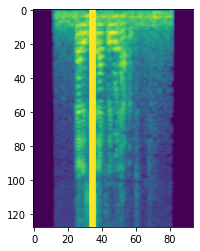

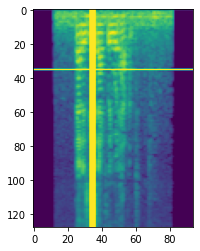

In [ ]:
freq_mask = tfio.audio.freq_mask(train_data[1], param=25)
time_mask = tfio.audio.time_mask(freq_mask, param=25)

plt.figure()
plt.imshow(freq_mask.numpy())

plt.figure()
plt.imshow(time_mask.numpy())

In [ ]:
train_data = train_data[:,:,:,np.newaxis]
print(train_data.shape)
val_data = val_data[:,:,:,np.newaxis]
print(val_data.shape)
test_data = test_data[:,:,:,np.newaxis]
print(test_data.shape)

(9896, 128, 94, 1)
(261, 128, 94, 1)
(2233, 128, 94, 1)


In [ ]:
CNNmodel = Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(train_data.shape[1],train_data.shape[2],1)))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
CNNmodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 126, 92, 32)       320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 63, 46, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 63, 46, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 61, 44, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 22, 64)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 30, 22, 64)       

In [ ]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=30, verbose=1, mode='auto')
model_history = CNNmodel.fit(np.array(train_data),np.array(train_labels),batch_size=32,epochs=100,validation_data=(np.array(val_data), np.array(val_labels)),callbacks=[checkpoint,early])
CNNmodel = load_model("model.h5")
score, acc = CNNmodel.evaluate(np.array(val_data), np.array(val_labels), verbose=0)
print('Val accuracy:', acc)

Epoch 1/100
308/310 [============================>.] - ETA: 0s - loss: 1.9486 - accuracy: 0.1704
Epoch 1: val_accuracy improved from -inf to 0.16858, saving model to model.h5
310/310 [==============================] - 6s 16ms/step - loss: 1.9482 - accuracy: 0.1703 - val_loss: 2.1755 - val_accuracy: 0.1686
Epoch 2/100
308/310 [============================>.] - ETA: 0s - loss: 1.7474 - accuracy: 0.2362
Epoch 2: val_accuracy improved from 0.16858 to 0.33716, saving model to model.h5
310/310 [==============================] - 5s 16ms/step - loss: 1.7464 - accuracy: 0.2366 - val_loss: 1.6655 - val_accuracy: 0.3372
Epoch 3/100
308/310 [============================>.] - ETA: 0s - loss: 1.5880 - accuracy: 0.3466
Epoch 3: val_accuracy did not improve from 0.33716
310/310 [==============================] - 4s 14ms/step - loss: 1.5878 - accuracy: 0.3465 - val_loss: 1.5702 - val_accuracy: 0.3333
Epoch 4/100
308/310 [============================>.] - ETA: 0s - loss: 1.5014 - accuracy: 0.3921
Epoch 

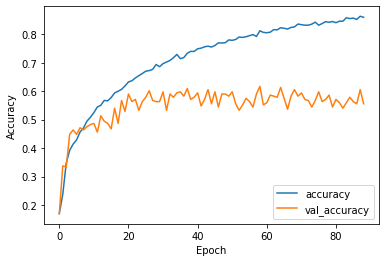

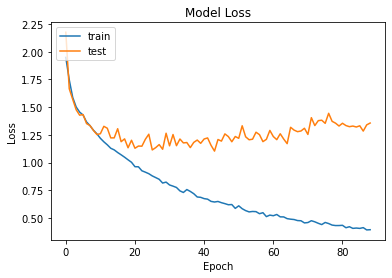

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       359
           1       0.72      0.65      0.68       390
           2       0.53      0.50      0.51       395
           3       0.61      0.72      0.66       320
           4       0.55      0.56      0.55       370
           5       0.54      0.48      0.51       399

    accuracy                           0.58      2233
   macro avg       0.58      0.58      0.58      2233
weighted avg       0.58      0.58      0.58      2233

[[208   3  33  46  13  56]
 [  6 255  43  20  46  20]
 [ 69  31 198  33  33  31]
 [ 35   3  23 230  17  12]
 [ 13  44  35  30 206  42]
 [ 67  20  44  17  59 192]]
val accuracy: 61.685824394226074
train accuracy: 95.3314483165741
test accuracy 57.725033587102544


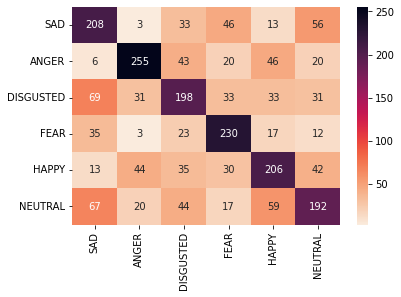

In [ ]:
score, trainacc = CNNmodel.evaluate(np.array(train_data), np.array(train_labels), verbose=0)
y_pred = CNNmodel.predict(test_data)
report=metrics.classification_report(test_labels,np.argmax(y_pred,axis=1)) 
print(report)

matrix = metrics.confusion_matrix(test_labels ,np.argmax(y_pred,axis=1))
sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r',xticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'],yticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'])
print(matrix)

print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(test_labels,np.argmax(y_pred,axis=1))*100)